# Introduction to Probabilistic Graphical Models: Practical session 1



This notebook is the solution proposed by **[Benjamin LAZARD](https://www.linkedin.com/in/benjaminlazard/)** to *Lab 1* of the course *Introduction to Probabilistic Graphical Models* taught at *Telecom Paristech* by **[Pr. Umut Simsekli](https://perso.telecom-paristech.fr/simsekli/)** (2019 version) in the context of the Msc data-science, a Master delivered by *Ecole Polytechnique* as part of the **[NewUni](https://www.insidehighered.com/news/2018/06/28/france-considers-plan-create-university-mit)** groupment of universities. 

### References:
1. [Explanatory videos about Forward-backward algorithm](https://www.youtube.com/watch?v=M7afek1nEKM) (from ML14.5 to ML14.18)
2. [HMM implementation in python](https://github.com/atcemgil/notes/blob/master/HiddenMarkovModel.py)
3. [Use of logarithms in HMM computations](http://bozeman.genome.washington.edu/compbio/mbt599_2006/hmm_scaling_revised.pdf).

## Question 0 (log sum trick):

How can we compute $s = log\left( \sum\limits_{i=1}^n e^{v_i}\right)$ where $\forall v_i$,  $v_i < 0, |v_i| >> 1$?

The problem is that computing the exponential of such high negative values lead to underflows $\left( \text{because }e^{-\text{ a lot}}=\text{peanuts}\right)$, and then overflows in the $log$ $\left( \text{because }log(\text{peanuts})= -\text{a lot}\right)$.

One possible trick is to notice that $\forall a \in |R$:
$$
a + log\left( \sum\limits_{i=1}^n e^{v_i-a}\right)
= log(e^a) + log\left( \sum\limits_{i=1}^n e^{v_i-a}\right)
= log\left( e^a\sum\limits_{i=1}^n e^{v_i-a}\right)
= s
$$

If we pick a $a$ that shifts the center of the $V = \{v_i, \forall i \in [1, I]\}$, the exponential terms will be bigger, and the log operation more accurate.

Let us test this with $V = \{-1234, -1235\}$ with $a = -1235$. 
This way, $V' = "V-a" = \{1, 0\}$ the exponential of which is numerically stable.

First let us see what happens with the straightforward method:

In [2]:
import numpy as np
v = np.array([-1234, -1235])
print(np.log(np.exp(v).sum()))

-inf


/home/rashed/.local/share/virtualenvs/Probability-and-Inference-luj-rrT2/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log
  This is separate from the ipykernel package so we can avoid doing imports until


So it is a good idea to implement this method.

In [3]:
def logsum(v):
    a = min(v)
    return a + np.log(np.exp(v - a).sum())

print(logsum(v))

-1233.6867383124818


## Subject:

A robot is moving across a circular corridor. We assume that the possible positions of the robot is a discrete set with
$N$ locations. The initial position of the robot is unknown and assumed to be uniformly distributed. At each step $k$,
the robot stays where it is with probability $\epsilon$, or moves to the next point in counter-clock direction with probability
$1 - \epsilon$. At each step $k$, the robot can observe its true position with probability $w$. With probability $1-w$, the position sensor fails and gives a measurement that is independent from the true position (uniformly distributed).

![Robot experiment illustration](https://drive.google.com/uc?exprt=view&id=1fhG1M9RRbHO5A1_GMlzsz9-B0dmD98SW)

## Question 1

What Hidden Markov Model can we come up with ?
- Let use denote $ X_k \in \mathcal{X} = \left[0, N-1\right]$ the *true* position of the robot at step k
- Let use denote $Y_k \in \mathcal{Y} = \mathcal{X} = \left[0, N-1\right]$ the *observed* position of the robot at step k

With the probability set defined in the subject, this leads to the following Markov Model

![HMM model](https://upload.wikimedia.org/wikipedia/commons/thumb/8/83/Hmm_temporal_bayesian_net.svg/833px-Hmm_temporal_bayesian_net.svg.png)

We can be more specific:

![Robot model](https://drive.google.com/uc?exprt=view&id=0B4-sjPft_IJGckNzMXAyQmhCVndTMW56MjBGMGpmZHh0U0Nr)

(**yeah I know** it's ugly, but I didn't want to waste time digitalizing this)

## Question 2:

Mathematical formalization of this model:

We will use a vectorial notation: $p(x_k) = \begin{pmatrix}a_1\\...\\a_{N-1}\end{pmatrix}$ where $a_i$ is the probability that the robot is at location $i$ at step $k$.

- The transition model is $T = p(x_k | x_{k-1}) = \epsilon I_{N\times N} + (1-\epsilon)J_{N\times N}$ where $J$ is the matrix obtained by permutating all rows from $I$ 1 increment to the left in a circular permutation fashion.
- The observation model is $O = p(y_k | x_{k}) =  w\delta(x_k - y_k) + (1-w)U_{(N-1)}(1-\delta(x_k - y_k))$ where $\delta(x) = I$ if $x = 0_N$ and $0_N$ otherwise, and $U_{(N-1)}$ is the uniform distribution over $N-1$ elements.

For example with $n = 3$ we have $I = \begin{pmatrix}1 & 0 & 0\\0 & 1 & 0\\0 & 0 & 1\end{pmatrix}$ and $J = \begin{pmatrix}0 & 0 & 1\\1 & 0 & 0\\0 & 1 & 0\end{pmatrix}$

## Question 3:

Here are some interesting notations.
Let us denote $n$ the current position of the robot.
1. Distribution of the robot's current position given the observations so far: $p(x_n | y_{1:n})$
2. Distribution of the robot's position at step k given the observations so far: $p(x_k | y_{1:n})$
3. Distribution of the robot's next position given the observations so far: $p(x_{n+1} | y_{1:n})$
4. Distribution of the robot's next sensor reading given the observations so far: $p(y_{n+1} | y_{1:n})$
5. Distribution of the robot's initial location given the observations so far: $p(x_{1} | y_{1:n})$
6. Most likely position of the robot given the observations so far: $\underset{a}{\text{argmax}} \; p(x_{n} = a \,| y_{1:n})$
7. Most likely trajectory of the robot given the observations so far: $\underset{a_{1:n}}{\text{argmax}} \; p(x_{1:n} = a_{1:n} \,| y_{1:n})$

## Question 4:

Let us simulate the behavior of the robot.
The initial position of the robot is assumed to be location 0.

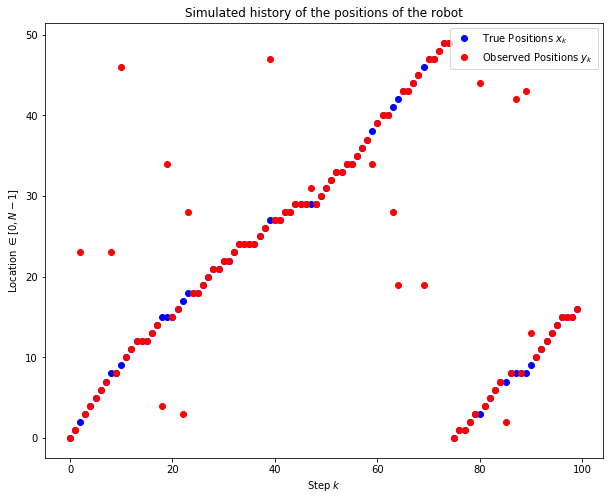

In [4]:
import numpy as np
from numpy.random import choice as pickValue
import matplotlib.pyplot as plt

# Number of possible locations
N = 50
# Number of steps studied
k_max = 100
# Probability transitions
ϵ, w = 0.3, 0.8
# Matrix transitions and observations:
I = np.eye(N)
J = np.roll(I, 1, axis=0) # Circular permutation
T = ϵ * I + (1-ϵ) * J
O = (1-w)/(N-1) * np.ones((N, N)) + (w - (1-w)/(N-1)) * np.eye(N)

# Initial position p(x0) abreviated as p0 : knwon to be at location 0
p0 = np.ones(N) /N

# Simulation program
def simu_robot(N=N, k_max=k_max, T=T, O=O, p0=p0):
    steps = np.arange(start=1, stop=k_max, step=1) # Step k_max is not in the list and p0 is the value for k=0    
    
    # Let us define the 2 initial conditions and the format of the observations and true_positions
    # We adopt the vectorial notation for X. Though it isn't the simplest solution in this particular scenario,
    # It makes scalability easier (same method works with more complex transition matrixes)
    init = np.zeros(N)
    init[0] = 1.
    true_positions = [init]
    observations = [0]
    del init
    
    # Let us compute these probabilities and return a specific set of positons and observations
    for k in steps:
        # For true positions
        probas = np.dot(T, true_positions[-1])
        # pickValue(N, p), choses one value among the integers of range(N), each with probability mass p
        next_position = I[:, pickValue(N, p=probas)]
        true_positions.append(next_position)
        
        # For observations
        probas = np.dot(O, next_position)
        # pickValue(N, p), choses one value among the integers of range(N), each with probability mass p
        next_observation = pickValue(N, p=probas)
        observations.append(next_observation)
    
    # Convert this vectors to the value of the location they represent (the only index where the coordinate is 1)
    true_positions = [ np.where(x==1)[0][0] for x in true_positions]
    steps = np.insert(steps, 0, 0.) # initialization which was not part of the loop
    
    return steps, true_positions, observations

# Plot
steps, true_positions, observations = simu_robot()
plt.figure(figsize=(10,8))
plt.plot(steps, true_positions, 'bo', label="True Positions $x_k$")
plt.plot(steps, observations, 'ro', label="Observed Positions $y_k$")
plt.legend()
plt.title("Simulated history of the positions of the robot")
plt.xlabel("Step $k$")
plt.ylabel("Location $\in [0,N-1]$")
plt.show()

## Question 5:

Let us compute 
1. The *filtering distribution* at step n: $p(x_n | y_{1:n})$
2. The *filtering distribution* at step k: $p(x_k | y_{1:n})$
3. The *smoothing distribution* at step n: $\underset{a}{\text{argmax}} \; p(x_{n} = a \,| y_{1:n})$

To do so, we will use the **forward-backward algorithm**. This is an instance of [dynamic programming](https://en.wikipedia.org/wiki/Dynamic_programming): a technique that takes a complex problem and breaks it down into simpler problems, that must be solved in sequential steps to find the solution for the original problem.

### 1. Finding $p(x_k | y_{1:n})$

We have the following:

$\begin{equation}\begin{split}
p(x_k | y_{1:n}) &= \frac{1}{p(y_{1:n})}\times p(x_k, y_{1:n}) = \frac{1}{p(y_{1:n})}\times p(x_k, y_{1:k}, y_{k+1:n}) &\quad \text{ using Bayes' relation and splitting the vector in 2}\\
&= \frac{1}{p(y_{1:n})}\times p(y_{k+1:n} | x_k, y_{1:k})p(x_k, y_{1:k})&\quad \text{ using conditional dependency}\\
&= \frac{1}{p(y_{1:n})}\times p(y_{k+1:n} | x_k)p(x_k, y_{1:k})&\quad \text{ using the Markov model: } y_{k+1:n} \text{depends on } x_k \text{only}  \\
\end{split}\end{equation}$

<br>

this factorization motivates the forward-backward algorithm:
- **Forward step**: compute $p(x_k, y_{1:k})$
- **Backward step**: compute $p(y_{k+1:n} | x_k)$

The names come from the recursive way of computing them as you can see below: we have a technique to compute the $\alpha_k$ from the index 1 to n in ascending order (forward), and $\beta_k$ from the index n to 1 in descending order (backward)

#### 1.1 Forward step computation

$\begin{equation}\begin{split}
p(x_k, y_{1:k}) &= \sum_{x_{k-1}} p(x_k, y_{1:k}, x_{k-1}) &\quad \text{ using the Law of total probabilities}\\
&= \sum_{x_{k-1}}p(y_k | y_{1:k-1}, x_{k-1}, x_k)p(y_{1:k-1}, x_{k-1}, x_k) &\quad \text{ using conditional dependency}\\
&= \sum_{x_{k-1}}p(y_k | y_{1:k-1}, x_{k-1}, x_k)p(x_k | y_{1:k-1}, x_{k-1})p(x_{k-1}, y_{1:k-1}) &\quad \text{ using conditional dependency}\\
&= \sum_{x_{k-1}}p(y_k | x_k)p(x_k | x_{k-1})p(x_{k-1}, y_{1:k-1}) &\quad \text{ using Markov Model simplifications}\\
\end{split}\end{equation}$

With the notation $\alpha_k = p(x_k, y_{1:k})$, we get that 

$$\alpha_k = \sum_{x_{k-1}}p(y_k | x_k)p(x_k | x_{k-1})\alpha_{k-1} \quad\text{for } k >2\text{, and}\quad \alpha_1 = p(x_1, y_{1}) = p(x_1)p(y_{1}|x_1)$$

In our model, we recognize:
- the transition probability **prediction step**: $\alpha'_k = p(x_k | x_{k-1})\alpha_{k-1} = T\alpha_{k-1}$ (matricial operation)
- the observation probability: **update step**: $p(x_k | x_{k-1})\alpha'_k = O_k^T\alpha'_k$ (matricial operation)

#### 1.2 Backward step computation

$\begin{equation}\begin{split}
p(y_{k+1:n} | x_k) &= \sum_{x_{k+1}} p(y_{k+2:n}, y_{k+1}, x_{k+1} |x_k) &\quad \text{ using the Law of tot. probabilities on } x_{k+1} \text{ , and the decomposition} y_{k+1:n} = y_{k+2:n} + y_{k+1}\\
&= \sum_{x_{k+1}} p(y_{k+2:n} |y_{k+1}, x_{k+1}, x_k)p(y_{k+1}, x_{k+1}| x_k) &\quad \text{ using conditional dependency}\\
&= \sum_{x_{k+1}} p(y_{k+2:n} |y_{k+1}, x_{k+1}, x_k)p(y_{k+1}| x_{k+1}, x_k)p(x_{k+1} | x_k) &\quad \text{ using conditional dependency}\\
&= \sum_{x_{k+1}} p(y_{k+2:n} |y_{k+1})p(y_{k+1}| x_{k+1})p(x_{k+1} | x_k) &\quad \text{ using Markov Model simplifications}\\
\end{split}\end{equation}$

With the notation $\beta_k = p(y_{k+1:n} | x_k)$, we get that 

$$\beta_k = \sum_{x_{k+1}} \beta_{k+1}p(y_{k+1}| x_{k+1})p(x_{k+1} | x_k) \quad\text{for } k\in \left[1, n-1\right] $$

How can we find $\beta_n$ ? 

Using its definition, $\beta_n \text{ is such that } \beta_{n-1} = p(y_n | x_n) = \sum_{x_{n}} \beta_{n}p(y_{n}| x_{n})p(x_{n} | x_{n-1}) = \sum_{x_{n}} \beta_{n}p(y_{n}, x_{n}| x_{n-1}) \Rightarrow \beta_n = 1$

In our model, we recognize:
- the transition probability **postdiction step**: $\beta'_k = \beta_{k}p(y_{k}| x_{k}) = \beta_{k} T$ (matricial operation)
- the observation probability: **update step**: $\beta_{k-1} = \beta'_{k}p(x_k | x_{k-1}) = O_k^T\beta'_k$ (matricial operation)

#### 1.3 the need for log-domain computations

So far we dealt with mathematical numbers. However the floating point representation of these numbers on computers is not enough accurate on nowadays programs. Because of that we will make computation in $log$-space whenever possible, so as to avoid small numbers being detected as 0.
This is what we illustrated at the beginning of this lab with the log-sum trick.

In [5]:
def forward(T=T, O=O, p0=p0, observations=observations, N=N, k_max=k_max):
    """
    Computes the list of α_k using alternating prediction and update steps
    
    Parameters
    ----------
    T: transition matrix p(x_{k} | x_{k-1})
    O : Observation matrix p(y_{k} | x_{k})
    p0: initial location probability vector
    
    Returns
    -------
        log_α, log_α_predicted: Predicted potentials log p(x_k, y_{1:k}),  log p(x_{k}, y_{1:k-1})
    """
    
    #Zero values in the initial probability vector are not welcome because of logarithmic computations
    if 0 in p0:
        print("No initial probability for the locations should be 0 for this function : else log(0) = -inf")
        return 0
    
    # Define the matrixes where we store the α values in logartihmic format
    log_α, log_α_predict = np.zeros((N, k_max)), np.zeros((N, k_max))
    
    # Initializing
    log_α_predict[:, 0] = np.log(p0)
    log_α[:, 0] = log_update_step(O[observations[0], :], log_α[:, 0])
    
    # Predict and Update in a looping fashion
    for k in range(1, k_max):
        log_α_predict[:, k] = log_predict_step(T, log_α[:, k-1])
        log_α[:, k] = log_update_step(O[observations[k], :], log_α_predict[:, k])

    return log_α, log_α_predict

def log_predict_step(T, log_α):
    """
    Computes p(x_{k}, y_{1:k-1}) given p(x_{k-1}, y_{1:k-1})
    
    Parameters
    ----------
    T: transition matrix p(x_{k} | x_{k-1})
    log_α : Filtered potential log p(x_{k-1}, y_{1:k-1})
    
    Returns
    -------
        log_α_predicted: Predicted potential log p(x_{k}, y_{1:k-1})
    """
    max_value = np.max(log_α)
    α = np.exp(log_α - max_value)
    log_α_predicted = max_value + np.log(np.dot(T, α))
    
    return log_α_predicted

def log_update_step(Ok, log_α_predicted):
    """
    Computes α_k_terms given p(x_{k}, y_{1:k-1})
    
    Parameters
    ----------
    Ok:  Observation probability given X_k: p(y_{k} | x_{k})
    log_α_predicted : Filtered potential log p(x_{k-1}, y_{1:k-1})
    
    Returns
    -------
        α_k_terms: terms of the sum to compute α_k as defined in the explanation
    """
    α_k_terms = np.log(Ok) + log_α_predicted
    
    return α_k_terms

# Important: When doing computation with logs probability of zero is not permitted as log(0) = -inf !!!
log_α, log_α_predict = forward(p0 = np.ones(N)/N)

In [6]:
def backward(T=T, O=O, observations=observations, N=N, k_max=k_max):
    """
    Computes the list of β_k using alternating postdiction and update steps
    
    Parameters
    ----------
    T: transition matrix p(x_{k} | x_{k-1})
    O : Observation matrix p(y_{k} | x_{k})
    p0: initial location probability vector
    
    Returns
    -------
        log_β, log_β_postdicted: Predicted potentials log p(y_{k+1:n} | x_k),  log p(y_{k:n} | x_k)
    """    
    # Define the matrixes where we store the α values in logartihmic format
    log_β, log_β_postdict = np.zeros((N, k_max)), np.zeros((N, k_max))
    
    # Initializing
    log_β_postdict[:, k_max-1] = np.zeros(N)
    log_β[:, k_max-1] = log_update_step(O[observations[k_max-1], :], log_β_postdict[:, k_max-1])
    
    # Predict and Update in a looping fashion
    for k in range(k_max-2, -1, -1):
        log_β_postdict[:, k] = log_postdict_step(T, log_β[:, k+1])
        log_β[:, k] = log_update_step(O[observations[k], :], log_β_postdict[:, k])

    return log_β, log_β_postdict

def log_postdict_step(T, log_β):
    """
    Computes p(x_{k}, y_{1:k-1}) given p(x_{k-1}, y_{1:k-1})
    
    Parameters
    ----------
    T: transition matrix p(x_{k} | x_{k-1})
    log_β_postdict : Filtered potential log p(x_{k-1}, y_{1:k-1})
    
    Returns
    -------
        log_β_postdict: Predicted potential log p(x_{k}, y_{1:k-1})
    """
    max_value = np.max(log_β)
    β = np.exp(log_β - max_value)
    log_β_postdict = max_value + np.log(np.dot(β, T))
    
    return log_β_postdict

log_β, log_β_postdict = backward()

### 2. Finding $\underset{a}{\text{argmax}} \; p(x_{n} = a \,| y_{1:n})$

Based on what we just achieved, we have the following:
$p\left(x_{k} = a \;| y_{1:n}\right) = \frac{1}{p(y_{1:n})}\beta_k \alpha_k = \frac{1}{p(y_{1:n})} \gamma_k$

In order to compute this quantity, we can:
- sum $log(\alpha_k) +  log(\beta_k)$
- use the exponential function to move back in the probability domain (shifted by the max value of the log (to avoid wrong computations, and because it doesn't change the normalization afterwards
- then normalize it (divide each term by the norm so that the sum is 1)... The norm is therefore $p(y_{1:n}) $
- for each k, pick the index of the maximum value of $\gamma_k$: this is the log-most-likely position

In practice, to visualize the "most-likely" positon as estimated by this algorithm, we wil plot a heatmap for each step k vertically. the darker the color on this plot, the higher the probability is high for a given step $k$ and location $N$.

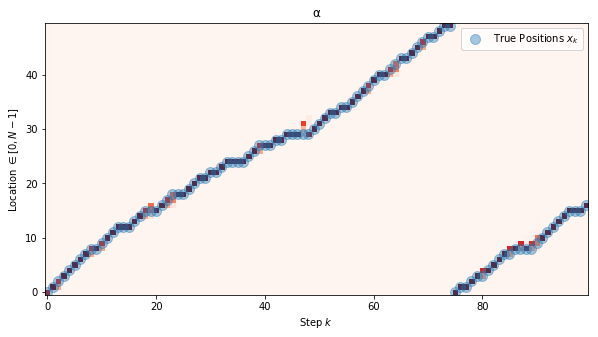

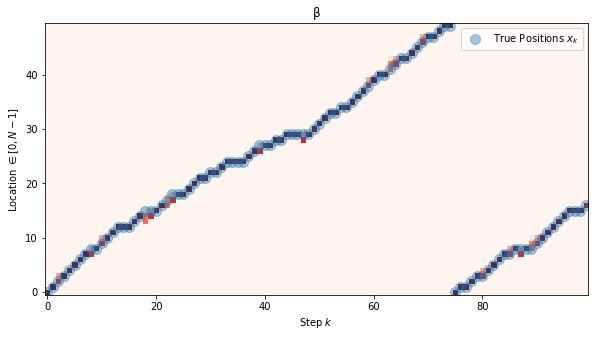

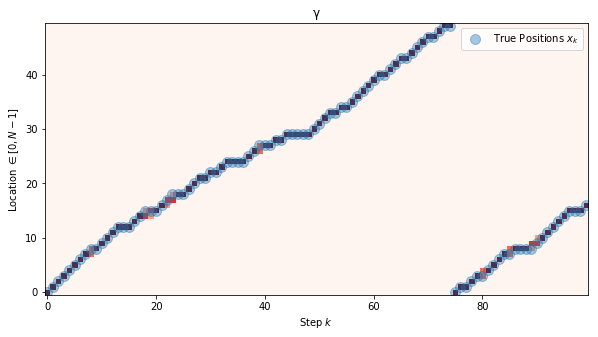

In [7]:
def smooth_it(log_α=log_α, log_β_postdict=log_β_postdict):
    return log_α + log_β_postdict

def normalize_exp(log_P, axis=None):
    a = np.max(log_P, keepdims=True, axis=axis)
    P = normalize_proba(np.exp(log_P - a), axis=axis)
    return P

def normalize_proba(A, axis=None):
    Z =  A.sum(axis=axis, keepdims=True)
    Z[np.where(Z == 0)] = 1
    return A / Z

# Retrieve true probabilities computed so far.
α = normalize_exp(log_α, axis=0)
β = normalize_exp(log_β, axis=0)
γ = normalize_exp(smooth_it(), axis=0)

##########################################
# Plotting
##########################################
color_map_name = "Reds"

def plot_robot_simu(x, title):
    plt.figure(figsize=(16,5))
    plt.plot(steps, true_positions, 
             'o', 
             alpha=.4, 
             ms=10, 
             label="True Positions $x_k$")
    plt.imshow(x, 
               interpolation='nearest', 
               cmap=color_map_name,
               label = title)
    ax = plt.gca()
    ax.invert_yaxis()
    plt.xlabel("Step $k$")
    plt.ylabel("Location $\in [0,N-1]$")
    plt.title(title)
    plt.legend()
    plt.show()

plot_robot_simu(α, 'α')
plot_robot_simu(β, 'β')
plot_robot_simu(γ, 'γ')

## Question 6:

Let us now place ourselves in another scenario, where at each step k, the robot can be kidnapped with probability $\kappa=0.1$. 

If the robot is kidnapped its new position is independent from its previous  position, uniformly distributed.

**Can we have another simple estimate of the trajectory and reuse our model?**

Of course ! The only difference is the matrix of transition. We can perform a matrix product with the $O$ from before, which simultes the kidnapping (adapting it with $\kappa$ instead of $w$), and the T from before.

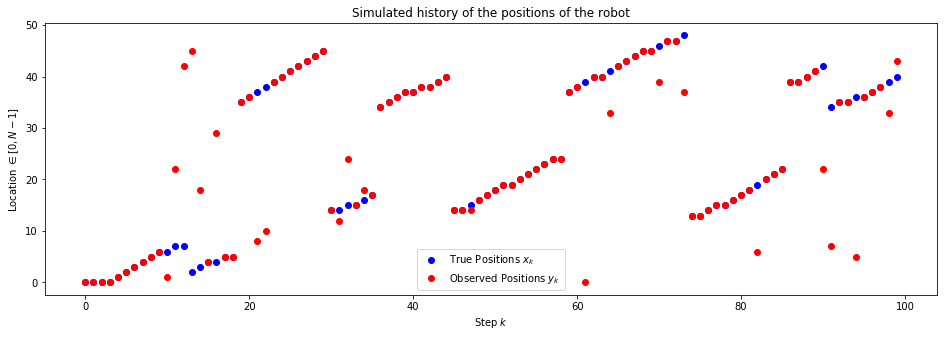

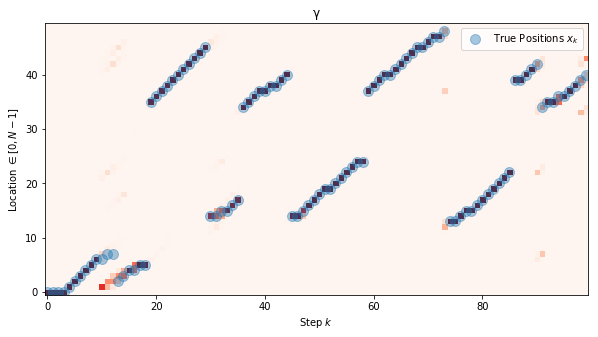

In [8]:
κ = 0.1
OO = κ/(N-1)* np.ones((N, N))+ (1-κ - κ/(N-1)) * np.eye(N)
T = np.dot(OO, T)


# Run simulation
steps, true_positions, observations = simu_robot(N=N, T=T, k_max=k_max, O=O, p0=p0)

# Plot simulation
plt.figure(figsize=(16,5))
plt.plot(steps, true_positions, 'bo', label="True Positions $x_k$")
plt.plot(steps, observations, 'ro', label="Observed Positions $y_k$")
plt.legend()
plt.title("Simulated history of the positions of the robot")
plt.xlabel("Step $k$")
plt.ylabel("Location $\in [0,N-1]$")
plt.show()

# Use the same algorithm
log_α, log_α_predict = forward(T=T, p0 = np.ones(N)/N, observations=observations)
log_β, log_β_postdict = backward(T=T, observations= observations)
α = normalize_exp(log_α, axis=0)
β = normalize_exp(log_β, axis=0)
γ = normalize_exp(smooth_it(log_α=log_α, log_β_postdict=log_β_postdict), axis=0)

# Plot the computed solution
# plot_robot_simu(α, 'α')
# plot_robot_simu(β, 'β')
plot_robot_simu(γ, 'γ')